In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.cluster import KMeans,  DBSCAN
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    StratifiedGroupKFold, 
    cross_validate
)
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import xgboost as xg

In [24]:
# Importing required libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Reading CSV files into DataFrames
features = pd.read_csv('Features data set.csv')  # Features dataset
sales = pd.read_csv('sales data-set.csv')  # Sales dataset
stores = pd.read_csv('stores data-set.csv')  # Stores dataset

# Dropping the 'IsHoliday' column from the features DataFrame
features = features.drop(['IsHoliday'], axis=1)

# Merging the sales and features DataFrames on 'Store' and 'Date' columns
combined = sales.merge(features, on=['Store', 'Date'])

# Merging the combined DataFrame with the stores DataFrame on the 'Store' column
combined = combined.merge(stores, on=['Store'])

# Filling missing values (NaNs) in the combined DataFrame with 0
combined = combined.fillna(value=0)

# Grouping the data by several columns and summing up the values for each group
merged_df = combined.groupby(['Store', 'Date', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
                               'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size'], as_index=False).sum()

# Dropping the 'Dept' column from the grouped DataFrame
merged_df = merged_df.drop(['Dept'], axis = 1)

# Rounding all numerical values in the DataFrame to 3 decimal places
merged_df = merged_df.round(3)

# Encoding the 'Type' column using LabelEncoder (converting categorical values to numerical)
label_encoder = LabelEncoder()
merged_df['Type'] = label_encoder.fit_transform(merged_df['Type'])

# Displaying summary info of the merged DataFrame to understand its structure
merged_df.info()

# Saving the final merged DataFrame to a CSV file
csv_file_path = "merged_df.csv"
merged_df.to_csv(csv_file_path, index=False)

# Printing the first 5 rows of the merged DataFrame to verify the result
print(merged_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   IsHoliday     6435 non-null   bool   
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   MarkDown1     6435 non-null   float64
 6   MarkDown2     6435 non-null   float64
 7   MarkDown3     6435 non-null   float64
 8   MarkDown4     6435 non-null   float64
 9   MarkDown5     6435 non-null   float64
 10  CPI           6435 non-null   float64
 11  Unemployment  6435 non-null   float64
 12  Type          6435 non-null   int32  
 13  Size          6435 non-null   int64  
 14  Weekly_Sales  6435 non-null   float64
dtypes: bool(1), float64(10), int32(1), int64(2), object(1)
memory usage: 685.1+ KB
   Store        Date  IsHoliday  Temperature  Fuel_Price  MarkDown1  \
0      

In [25]:
# Converting 'Date' column to datetime format with the day-first option (e.g., DD/MM/YYYY)
merged_df['Date'] = pd.to_datetime(merged_df['Date'], dayfirst=True)

# Extracting the 'Year' from the 'Date' column and creating a new 'Year' column
merged_df['Year'] = merged_df['Date'].dt.year

# Extracting the 'Month' from the 'Date' column and creating a new 'Month' column
merged_df['Month'] = merged_df['Date'].dt.month

# Extracting the 'WeekOfYear' from the 'Date' column and creating a new 'WeekOfYear' column
merged_df['WeekOfYear'] = merged_df['Date'].dt.isocalendar().week

# Converting 'WeekOfYear' to an integer type for more efficient memory usage
merged_df['WeekOfYear'] = merged_df['WeekOfYear'].astype(np.int32)

# Extracting the 'DayOfWeek' from the 'Date' column (0 = Monday, 6 = Sunday) and creating a new 'DayOfWeek' column
merged_df['DayOfWeek'] = merged_df['Date'].dt.dayofweek

# Sorting the DataFrame first by 'Store' and then by 'Date' to maintain a consistent order
merged_df = merged_df.sort_values(by=['Store', 'Date'])

# Initializing a new column 'Holiday_Weight' with a default value of 1 for all rows
merged_df['Holiday_Weight'] = 1

# Identifying the Super Bowl week: February, with week <= 6, and a Saturday (dayofweek == 6)
super_bowl_week = (merged_df['Date'].dt.month == 2) & (merged_df['Date'].dt.isocalendar().week <= 6) & (merged_df['Date'].dt.dayofweek == 6)

# Identifying Labor Day week: September, and the 36th week of the year
labor_day_week = (merged_df['Date'].dt.month == 9) & (merged_df['Date'].dt.isocalendar().week == 36)

# Identifying Thanksgiving season: Weeks 47 and 48 of the year (significant sales spike observed)
thanksgiving_week = merged_df['WeekOfYear'].isin([47, 48])

# Identifying the Christmas season: Weeks 49, 50, and 51 of the year (another spike in sales)
christmas_period = merged_df['WeekOfYear'].isin([49, 50, 51])

# Assigning a weight of 5 to rows that correspond to the identified holiday periods
merged_df.loc[super_bowl_week, 'Holiday_Weight'] = 5
merged_df.loc[labor_day_week, 'Holiday_Weight'] = 5
merged_df.loc[thanksgiving_week, 'Holiday_Weight'] = 5
merged_df.loc[christmas_period, 'Holiday_Weight'] = 5

# Creating a new column 'Weighted_Weekly_Sales' which adjusts 'Weekly_Sales' based on the 'Holiday_Weight'
merged_df['Weighted_Weekly_Sales'] = merged_df['Weekly_Sales'] * merged_df['Holiday_Weight']


Correlation of each feature with Weekly_Sales:
Size            0.810468
MarkDown1       0.179107
MarkDown5       0.173273
MarkDown4       0.139195
MarkDown3       0.120289
MarkDown2       0.080157
Month           0.076143
WeekOfYear      0.074211
Fuel_Price      0.009464
Year           -0.018378
Temperature    -0.063810
CPI            -0.072634
Unemployment   -0.106176
Store          -0.335332
Type           -0.598380
DayOfWeek            NaN
dtype: float64


c:\Users\eric\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\eric\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\eric\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


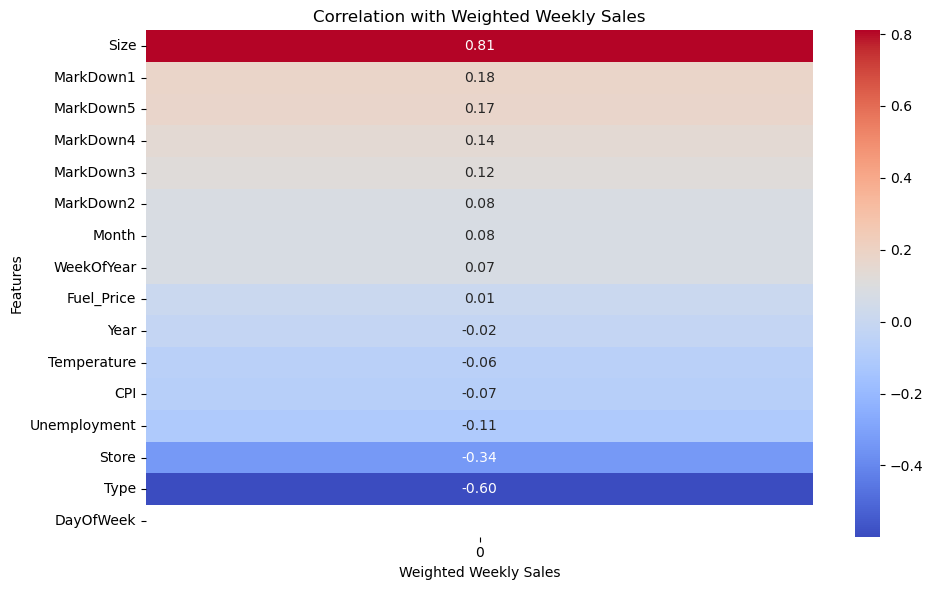

In [26]:
# Select only the numerical columns from the merged DataFrame
# Drop 'Weekly_Sales', 'Weighted_Weekly_Sales', and 'Holiday_Weight' columns as they are target variables or already used for computation
numeric_df = merged_df.select_dtypes(include=[np.number]).drop(columns=['Weekly_Sales', 'Weighted_Weekly_Sales', 'Holiday_Weight'])

# Compute the correlation of each numerical feature with the 'Weekly_Sales' column
# .corrwith() computes the correlation of each column in numeric_df with 'Weekly_Sales'
correlation = numeric_df.corrwith(merged_df['Weekly_Sales']).sort_values(ascending=False)

# Print the correlation of each feature with 'Weekly_Sales'
print("Correlation of each feature with Weekly_Sales:")
print(correlation)

# Create a heatmap to visualize the correlation values
plt.figure(figsize=(10, 6))  # Set the size of the figure for better readability

# Use seaborn's heatmap function to display the correlation values as a color map
# Convert the correlation series to a DataFrame for heatmap compatibility
sns.heatmap(correlation.to_frame(), annot=True, cmap="coolwarm", cbar=True, fmt=".2f")

# Set the title of the heatmap plot
plt.title("Correlation with Weighted Weekly Sales")

# Label the x-axis
plt.xlabel("Weighted Weekly Sales")

# Label the y-axis with feature names
plt.ylabel("Features")

# Adjust the layout to avoid overlap and make the plot look clean
plt.tight_layout()

# Show the heatmap plot
plt.show()


[0.22668357 0.15088925 0.12000745 0.1082481  0.09263525 0.08276386
 0.07737273 0.06482042 0.04500111 0.01876137 0.01281688]


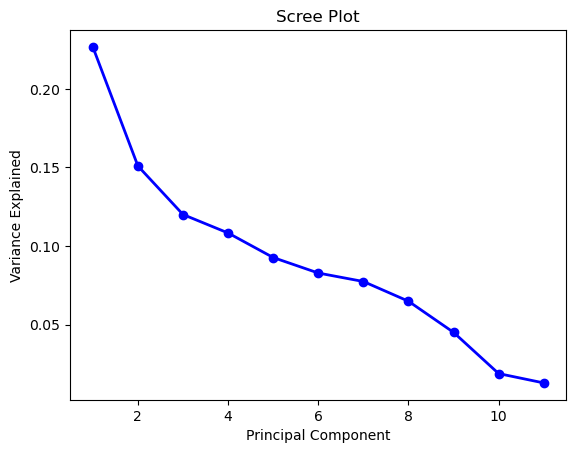

In [27]:
# Importing necessary libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Initializing the PCA and StandardScaler objects
pca = PCA()  # Principal Component Analysis (PCA) object to perform dimensionality reduction
scaler = StandardScaler()  # StandardScaler object to scale/standardize the data

# Making a copy of the merged DataFrame to preserve the original unscaled data
combined_scaled = merged_df.copy()

# Scaling each numerical column individually to normalize the data
# This step is important because PCA is sensitive to the scale of the data

combined_scaled['Weekly_Sales'] = scaler.fit_transform(combined_scaled[['Weekly_Sales']])
combined_scaled['Temperature'] = scaler.fit_transform(combined_scaled[['Temperature']])
combined_scaled['Fuel_Price'] = scaler.fit_transform(combined_scaled[['Fuel_Price']])
combined_scaled['MarkDown1'] = scaler.fit_transform(combined_scaled[['MarkDown1']])
combined_scaled['MarkDown2'] = scaler.fit_transform(combined_scaled[['MarkDown2']])
combined_scaled['MarkDown3'] = scaler.fit_transform(combined_scaled[['MarkDown3']])
combined_scaled['MarkDown4'] = scaler.fit_transform(combined_scaled[['MarkDown4']])
combined_scaled['MarkDown5'] = scaler.fit_transform(combined_scaled[['MarkDown5']])
combined_scaled['CPI'] = scaler.fit_transform(combined_scaled[['CPI']])
combined_scaled['Unemployment'] = scaler.fit_transform(combined_scaled[['Unemployment']])
combined_scaled['Size'] = scaler.fit_transform(combined_scaled[['Size']])
combined_scaled['Weighted_Weekly_Sales'] = scaler.fit_transform(combined_scaled[['Weighted_Weekly_Sales']])
combined_scaled['Type'] = scaler.fit_transform(combined_scaled[['Type']])

# Display the first few rows of the scaled DataFrame
combined_scaled.head()

# Performing PCA on the scaled numerical features
# Here, the features selected for PCA are adjusted, in this case, removing 'Weekly_Sales' and 'Weighted_Weekly_Sales'
# PCA works better when there is no collinearity between the features, so we leave out the target variables

# Fit PCA model using the scaled features, excluding 'Weekly_Sales' and 'Weighted_Weekly_Sales'
pca.fit(combined_scaled[['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size', 'Type']])

# Output the explained variance ratio for each principal component
# This shows how much variance each principal component explains in the data
print(pca.explained_variance_ratio_)

# Creating an array of Principal Component (PC) numbers starting from 1
PC_values = np.arange(pca.n_components_) + 1

# Plotting the Scree Plot to visualize the explained variance ratio of each component
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')  # Title of the plot
plt.xlabel('Principal Component')  # Label for the x-axis (Principal Components)
plt.ylabel('Variance Explained')  # Label for the y-axis (Explained Variance)
plt.show()  # Display the plot


[0.22668357 0.15088925 0.12000745 0.1082481  0.09263525 0.08276386
 0.07737273 0.06482042 0.04500111 0.01876137 0.01281688]


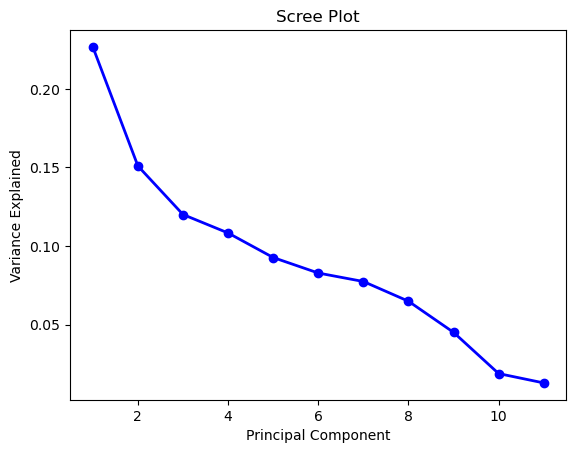

In [28]:
pca = PCA()
scaler = StandardScaler()

#making a copy to preserve the original unscaled df
combined_scaled = merged_df.copy()

#scaling each of the numerical columns
combined_scaled['Weekly_Sales'] = scaler.fit_transform(combined_scaled[['Weekly_Sales']])
combined_scaled['Temperature'] = scaler.fit_transform(combined_scaled[['Temperature']])
combined_scaled['Fuel_Price'] = scaler.fit_transform(combined_scaled[['Fuel_Price']])
combined_scaled['MarkDown1'] = scaler.fit_transform(combined_scaled[['MarkDown1']])
combined_scaled['MarkDown2'] = scaler.fit_transform(combined_scaled[['MarkDown2']])
combined_scaled['MarkDown3'] = scaler.fit_transform(combined_scaled[['MarkDown3']])
combined_scaled['MarkDown4'] = scaler.fit_transform(combined_scaled[['MarkDown4']])
combined_scaled['MarkDown5'] = scaler.fit_transform(combined_scaled[['MarkDown5']])
combined_scaled['CPI'] = scaler.fit_transform(combined_scaled[['CPI']])
combined_scaled['Unemployment'] = scaler.fit_transform(combined_scaled[['Unemployment']])
combined_scaled['Size'] = scaler.fit_transform(combined_scaled[['Size']])
combined_scaled['Weighted_Weekly_Sales'] = scaler.fit_transform(combined_scaled[['Weighted_Weekly_Sales']])
combined_scaled['Type'] = scaler.fit_transform(combined_scaled[['Type']])
combined_scaled.head()

#performing PCA on the numerical features. Which features we select will likely need tweaking
#pca.fit(combined_scaled[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size', 'Weighted_Weekly_Sales']])

pca.fit(combined_scaled[['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size', 'Type']])

print(pca.explained_variance_ratio_)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [29]:
# Define features and target variable
X = merged_df.drop(columns=['Weekly_Sales', 'Date', 'Weighted_Weekly_Sales'])
X['Type'] = label_encoder.fit_transform(X['Type'])

y = merged_df['Weighted_Weekly_Sales']

# Initialize and fit Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=123)
rf_model.fit(X, y)

# Calculate feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances from Random Forest:")
print(feature_importances)


Feature Importances from Random Forest:
           Feature  Importance
17  Holiday_Weight    0.612166
12            Size    0.255440
0            Store    0.041309
15      WeekOfYear    0.029858
9              CPI    0.016684
2      Temperature    0.016077
10    Unemployment    0.010396
6        MarkDown3    0.005169
3       Fuel_Price    0.004341
14           Month    0.001911
5        MarkDown2    0.001451
11            Type    0.001121
8        MarkDown5    0.001031
4        MarkDown1    0.001017
7        MarkDown4    0.000961
1        IsHoliday    0.000943
13            Year    0.000125
16       DayOfWeek    0.000000


Mean Squared Error: 92001869190.70071
R-squared: 0.714416993298542


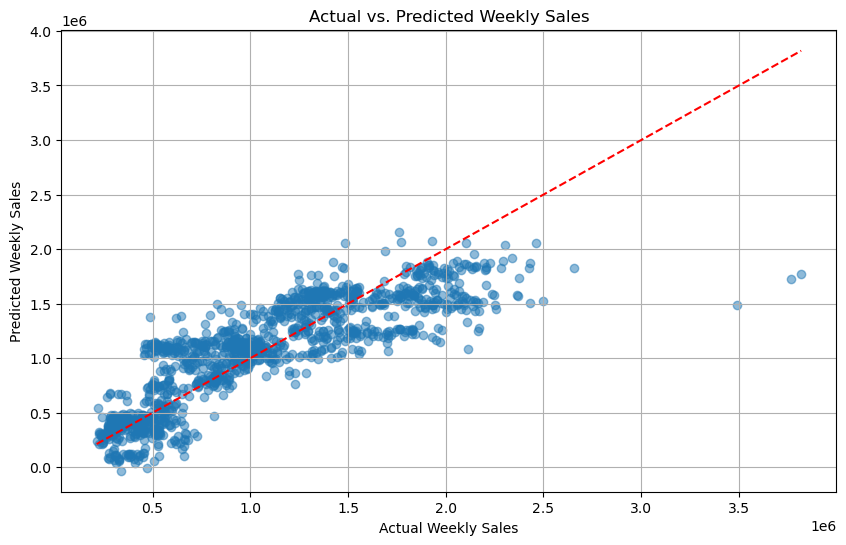

[-7.04017345e+03 -8.24205899e+04  2.54511266e+03  7.58812340e+03
  1.39246763e+00  3.59266251e+00  6.38879711e+00  2.15632520e+00
  3.64710536e+00 -1.71660994e+03 -2.05919087e+04  1.13211880e+05
  7.76210165e+00 -3.35700739e+04  7.15969544e+03 -2.87235507e+03
  8.47530285e+04]


In [30]:
# Split the dataset into features (X) and target (y)
# Drop 'Date', 'Weekly_Sales', 'DayOfWeek', and 'Weighted_Weekly_Sales' from the features (X)
# 'Weekly_Sales' is the target variable, so it is separated as 'y'
X = merged_df.drop(columns=['Date', 'Weekly_Sales', 'DayOfWeek', 'Weighted_Weekly_Sales'])
y = merged_df['Weekly_Sales']

# Initialize a LabelEncoder object to convert categorical variables into numeric form
label_encoder = LabelEncoder()

# Apply label encoding on the 'Type' and 'IsHoliday' columns to convert them into numeric labels
X['Type'] = label_encoder.fit_transform(X['Type'])
X['IsHoliday'] = label_encoder.fit_transform(X['IsHoliday'])

# Initialize a Linear Regression model
linear_regression_model = LinearRegression()

# Split the data into training and testing sets (80% training, 20% testing)
# train_test_split ensures that the model is evaluated on unseen data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the linear regression model to the training data
linear_regression_model.fit(x_train, y_train)

# Predict the target values (Weekly_Sales) using the test data
y_pred = linear_regression_model.predict(x_test)

# Calculate Mean Squared Error (MSE) and R-squared (R2) for model performance evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the model's Mean Squared Error and R-squared values
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Create a scatter plot comparing actual vs. predicted Weekly Sales
# 'alpha=0.5' makes the points semi-transparent to avoid overlap
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)

# Plot a red dashed line representing the line of perfect prediction (where actual = predicted)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

# Add labels and title to the plot
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("Actual vs. Predicted Weekly Sales")
plt.grid(True)

# Display the plot
plt.show()

# Print the coefficients of the linear regression model (importance of each feature)
print(linear_regression_model.coef_)


In [31]:
import pandas as pd
import numpy as np
#Predict weekly sales for 2013
output_dir = 'linearRegressionStorePredictions'
os.makedirs(output_dir, exist_ok=True) 

# Load the synthetic adjusted 2013 dataset
synthetic_2013_file_path = 'synthetic_holiday_weekly_2013_adjusted_data.csv'
synthetic_2013_df = pd.read_csv(synthetic_2013_file_path)

# Output directory for predictions
output_dir = 'linearRegressionStorePredictions'
os.makedirs(output_dir, exist_ok=True)

# Ensure the 'Date' column is in datetime format
synthetic_2013_df['Date'] = pd.to_datetime(synthetic_2013_df['Date'])

# Prepare feature columns for prediction, excluding target columns
feature_columns = synthetic_2013_df.columns.drop(['Date', 'Weekly_Sales', 'DayOfWeek', 'Weighted_Weekly_Sales'])

# Ensure features like `Type` and `IsHoliday` are encoded properly
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

synthetic_2013_df['Type'] = label_encoder.fit_transform(synthetic_2013_df['Type'])
synthetic_2013_df['IsHoliday'] = label_encoder.fit_transform(synthetic_2013_df['IsHoliday'])

# Sanitize input data
def sanitize_input(input_df):
    input_df = input_df.replace([float('inf'), -float('inf')], float('nan'))  # Replace infinities with NaN
    input_df = input_df.fillna(0)  # Replace NaN with 0
    return input_df

# Prepare the sanitized feature set
X = sanitize_input(synthetic_2013_df[feature_columns])

# Predict weekly sales using the linear regression model
predicted_sales = linear_regression_model.predict(X)

# Combine predictions with dates for output
predictions_2013 = pd.DataFrame({
    'Date': synthetic_2013_df['Date'],
    'Store': synthetic_2013_df['Store'],
    'Predicted_Weekly_Sales': predicted_sales
})

predictions_2013['Predicted_Weekly_Sales'] = predictions_2013['Predicted_Weekly_Sales'].round(3)

# Save predictions to CSV
output_file = os.path.join(output_dir, 'predicted_sales_2013.csv')
predictions_2013.to_csv(output_file, index=False)

# Print completion message and show the first few rows
print(f"Predictions saved to {output_file}")
print(predictions_2013.head())

Predictions saved to linearRegressionStorePredictions\predicted_sales_2013.csv
        Date  Store  Predicted_Weekly_Sales
0 2013-01-02      1             1183349.845
1 2013-01-03      1             1150450.072
2 2013-01-09      1             1187052.284
3 2013-01-10      1             1177078.312
4 2013-01-16      1             1200373.456


Linear Regression
Mean Squared Error: 92001869190.70071
R-squared: 0.714416993298542


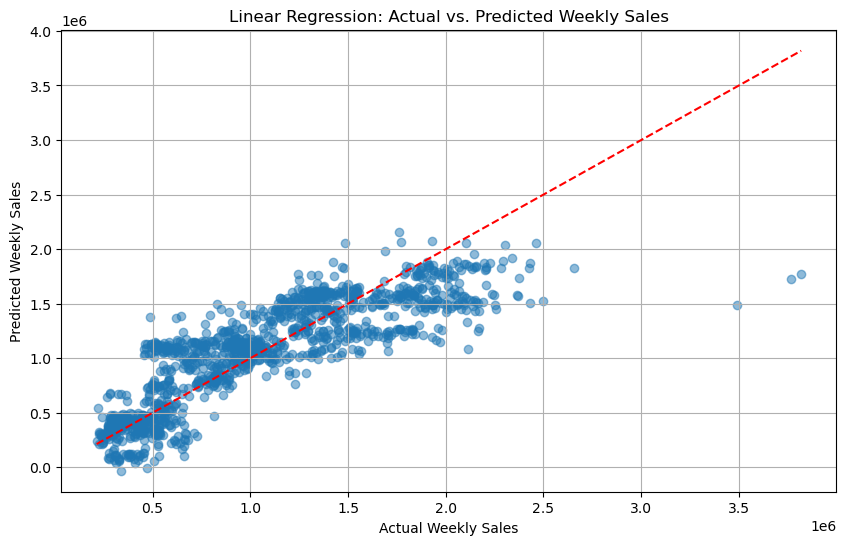

Best alpha for Lasso: 100
Lasso Regression
Mean Squared Error: 91993461644.31
R-squared: 0.71


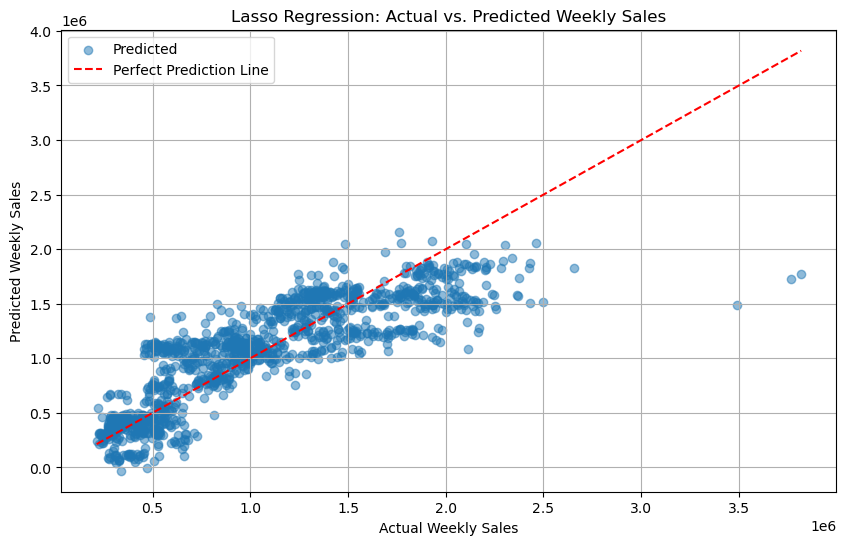

In [32]:
# Prepare data for Linear Regression and Lasso Regression
X_lr_lasso = merged_df.drop(columns=['Date', 'Weekly_Sales', 'DayOfWeek', 'Weighted_Weekly_Sales'])
y_lr_lasso = merged_df['Weekly_Sales']

label_encoder = LabelEncoder()
X_lr_lasso['Type'] = label_encoder.fit_transform(X_lr_lasso['Type'])
X_lr_lasso['IsHoliday'] = label_encoder.fit_transform(X_lr_lasso['IsHoliday'])

scaler = StandardScaler()
X_lr_lasso_scaled = scaler.fit_transform(X_lr_lasso)

# Splitting the data
x_train_lr_lasso, x_test_lr_lasso, y_train_lr_lasso, y_test_lr_lasso = train_test_split(
    X_lr_lasso, y_lr_lasso, test_size=0.2, random_state=42
)

### Linear Regression
linear_regression_model = LinearRegression()
linear_regression_model.fit(x_train_lr_lasso, y_train_lr_lasso)
y_pred_lr = linear_regression_model.predict(x_test_lr_lasso)

mse_lr = mean_squared_error(y_test_lr_lasso, y_pred_lr)
r2_lr = r2_score(y_test_lr_lasso, y_pred_lr)

print("Linear Regression")
print(f"Mean Squared Error: {mse_lr}")
print(f"R-squared: {r2_lr}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test_lr_lasso, y_pred_lr, alpha=0.5)
plt.plot([y_test_lr_lasso.min(), y_test_lr_lasso.max()], [y_test_lr_lasso.min(), y_test_lr_lasso.max()], 'r--')
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("Linear Regression: Actual vs. Predicted Weekly Sales")
plt.grid(True)
plt.show()

### Lasso Regression with Grid Search
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(Lasso(max_iter=10000), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(scaler.fit_transform(x_train_lr_lasso), y_train_lr_lasso)

# Retrieve the best alpha
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha for Lasso: {best_alpha}")

# Train Lasso model with the best alpha
lasso = Lasso(alpha=best_alpha, max_iter=10000)
lasso.fit(scaler.fit_transform(x_train_lr_lasso), y_train_lr_lasso)

# Predict on the test set
y_pred_lasso = lasso.predict(scaler.transform(x_test_lr_lasso))

# Evaluate the model
mse_lasso = mean_squared_error(y_test_lr_lasso, y_pred_lasso)
r2_lasso = r2_score(y_test_lr_lasso, y_pred_lasso)

print("Lasso Regression")
print(f"Mean Squared Error: {mse_lasso:.2f}")
print(f"R-squared: {r2_lasso:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test_lr_lasso, y_pred_lasso, alpha=0.5, label="Predicted")
plt.plot([y_test_lr_lasso.min(), y_test_lr_lasso.max()], [y_test_lr_lasso.min(), y_test_lr_lasso.max()], 'r--', label="Perfect Prediction Line")
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("Lasso Regression: Actual vs. Predicted Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()

Random Forest Regressor
Mean Squared Error: 9663109709.96
R-squared: 0.97


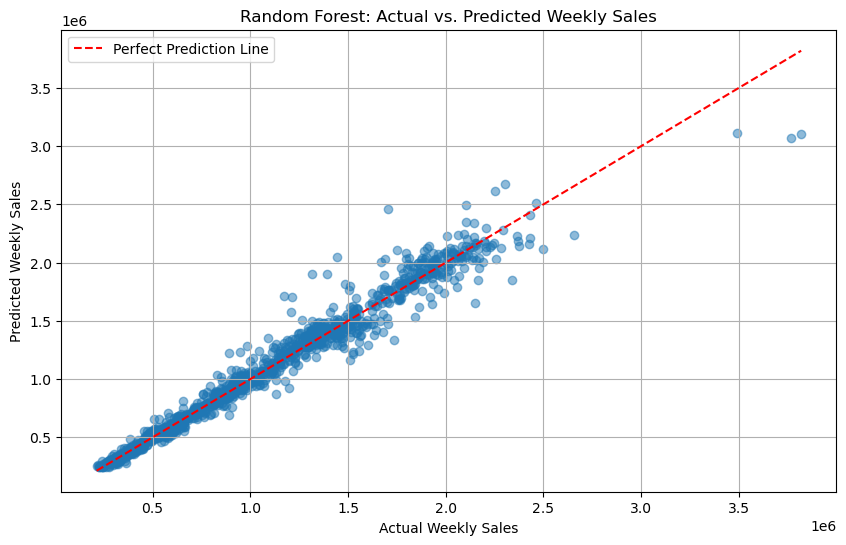


Feature Importances:
           Feature  Importance
12            Size    0.698426
0            Store    0.146592
9              CPI    0.060490
15      WeekOfYear    0.031488
16  Holiday_Weight    0.017155
10    Unemployment    0.016296
2      Temperature    0.009202
3       Fuel_Price    0.004770
11            Type    0.003643
6        MarkDown3    0.003532
14           Month    0.002333
7        MarkDown4    0.001507
4        MarkDown1    0.001500
8        MarkDown5    0.001306
5        MarkDown2    0.000791
1        IsHoliday    0.000695
13            Year    0.000274


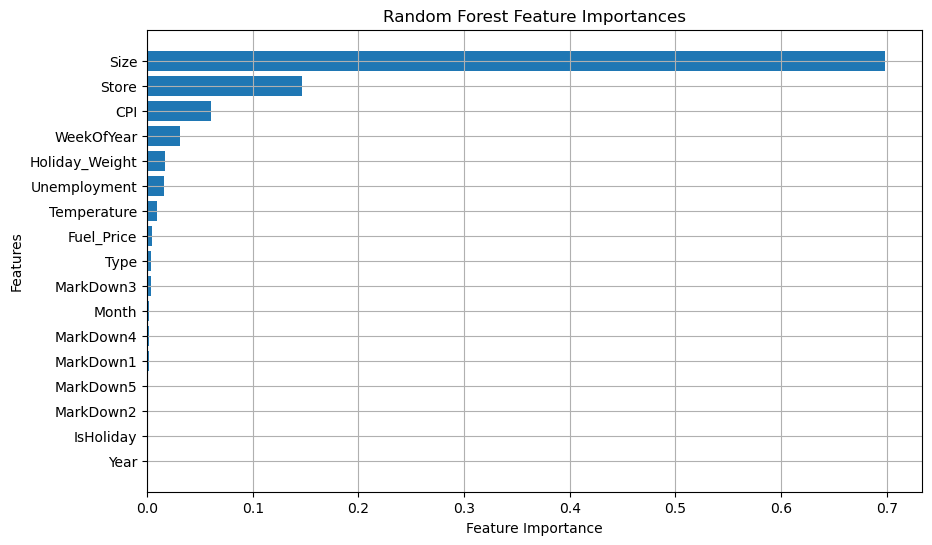

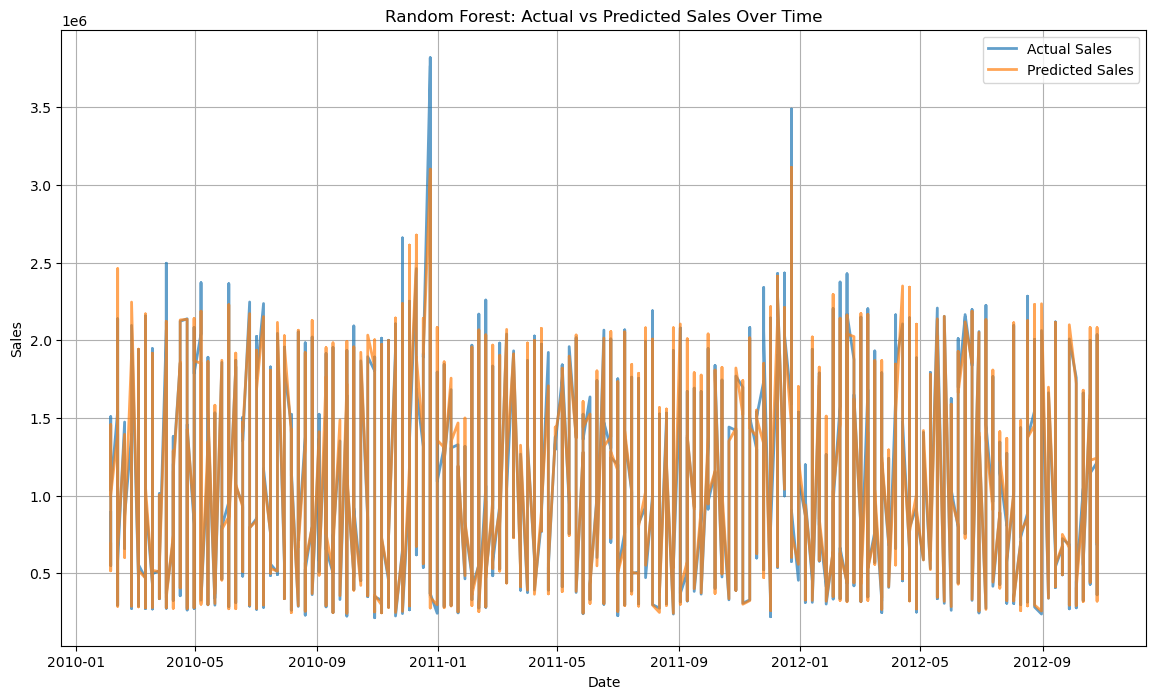

In [33]:
# Prepare the data
X = merged_df.drop(columns=['Weekly_Sales','Date', 'DayOfWeek', 'Weighted_Weekly_Sales'])  # Excluding target and irrelevant columns
y = merged_df['Weekly_Sales']

# Encode categorical variables
label_encoder = LabelEncoder()
if 'Type' in X.columns:
    X['Type'] = label_encoder.fit_transform(X['Type'])
if 'IsHoliday' in X.columns:
    X['IsHoliday'] = label_encoder.fit_transform(X['IsHoliday'])

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(x_train, y_train)

# Make predictions
y_pred_rf = random_forest_model.predict(x_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regressor")
print(f"Mean Squared Error: {mse_rf:.2f}")
print(f"R-squared: {r2_rf:.2f}")

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction Line")
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("Random Forest: Actual vs. Predicted Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()

# Feature importance analysis
feature_importances = random_forest_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df)

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

# Create a DataFrame for easier plotting
results_df = x_test.copy()
results_df['Actual Sales'] = y_test.values
results_df['Predicted Sales'] = y_pred_rf
results_df['Date'] = merged_df.loc[y_test.index, 'Date']  # Retrieve corresponding dates
results_df.sort_values(by='Date', inplace=True)  # Sort by date

# Plot actual vs predicted sales over time
plt.figure(figsize=(14, 8))
plt.plot(results_df['Date'], results_df['Actual Sales'], label="Actual Sales", alpha=0.7, linewidth=2)
plt.plot(results_df['Date'], results_df['Predicted Sales'], label="Predicted Sales", alpha=0.7, linewidth=2)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Random Forest: Actual vs Predicted Sales Over Time")
plt.legend()
plt.grid(True)
plt.show()


            Store  Month  WeekOfYear  DayOfWeek  IsHoliday  Temperature  \
Date                                                                      
2010-02-05      1      2           5          4      False        42.31   
2010-02-12      1      2           6          4       True        38.51   
2010-02-19      1      2           7          4      False        39.93   
2010-02-26      1      2           8          4      False        46.63   
2010-03-05      1      3           9          4      False        46.50   
...           ...    ...         ...        ...        ...          ...   
2011-12-02     45     12          48          4      False        50.19   
2011-12-09     45     12          49          4      False        46.57   
2011-12-16     45     12          50          4      False        39.93   
2011-12-23     45     12          51          4      False        42.27   
2011-12-30     45     12          52          4       True        37.79   

            Fuel_Price  

c:\Users\eric\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:41:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


MSE: 7647619893.349166
RMSE: 87450.67120010666
R2: 0.9734317509866265


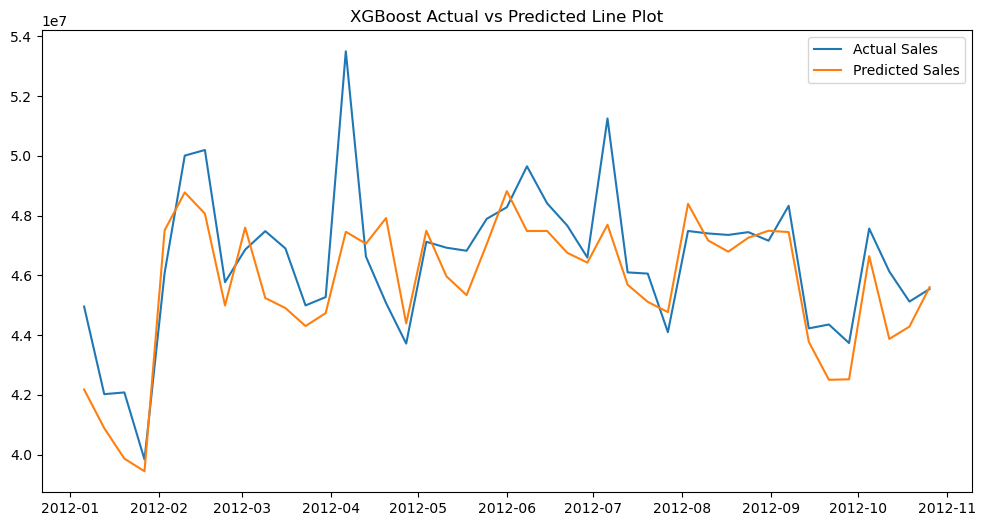

In [34]:
# Separate the feature columns (X) and the target column (y)
X = merged_df[['Date', 'Store', 'Month', 'WeekOfYear', 'DayOfWeek', 'IsHoliday', 'Temperature', 
               'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Size']]
y = merged_df[['Date', 'Weekly_Sales']]

# Set the 'Date' column as the index for both feature and target datasets
X = X.set_index('Date')
y = y.set_index('Date')

# Split data into training (2010 and 2011) and testing (2012) sets
x_train = pd.concat([X.loc['2010'], X.loc['2011']])
y_train = pd.concat([y.loc['2010'], y.loc['2011']])
x_test = X.loc['2012']
y_test = y.loc['2012']

# Print the training dataset to verify the split
print(x_train)

# Optionally, train-test split can be done using sklearn (commented out here)
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize the XGBoost regressor with a specific objective and CUDA support
xg_regressor = xg.XGBRegressor(objective='reg:linear', device='cuda')

# Optionally, perform cross-validation to evaluate model performance (commented out here)
# cv_scores = cross_val_score(xg_regressor, X, y, cv=10)

# Train the model using the training data
xg_regressor.fit(x_train, y_train)

# Predict the sales using the trained model on the test dataset
y_pred = xg_regressor.predict(x_test)

# Evaluate the model using MSE, RMSE, and R2 score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Convert predictions to a DataFrame for easier handling
y_pred = pd.DataFrame({'Date': y_test.index, 'Predicted': y_pred})
y_pred = y_pred.set_index('Date')

# Group actual and predicted values by date and sum them (useful for aggregated analysis)
y_test_sums = y_test.groupby(y_test.index).sum()
y_pred_sums = y_pred.groupby(y_pred.index).sum()

# Print evaluation metrics
#print("Cross Validation scores:", cv_scores)
#print("Mean cross-validation score:", cv_scores.mean())
print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", r2)

# Plot the actual vs predicted sales for visualization
plt.figure(figsize=(12, 6))
plt.plot(y_test_sums, label='Actual Sales')  # Line plot for actual sales
plt.plot(y_pred_sums, label='Predicted Sales')  # Line plot for predicted sales
plt.title("XGBoost Actual vs Predicted Line Plot")
plt.legend()
plt.show()


DBSCAN with eps=0.5: Silhouette Score = 0.484
DBSCAN with eps=1.0: Silhouette Score = 0.771
DBSCAN with eps=1.5: Silhouette Score = 0.792
DBSCAN with eps=2.0: Silhouette Score = 0.782

Best eps value based on Silhouette Score: 1.5
Best Silhouette Score: 0.792
Number of clusters: 3
Number of noise points: 30


C:\Users\eric\AppData\Local\Temp\ipykernel_35664\4083415701.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_dbscan['Cluster'] = final_labels


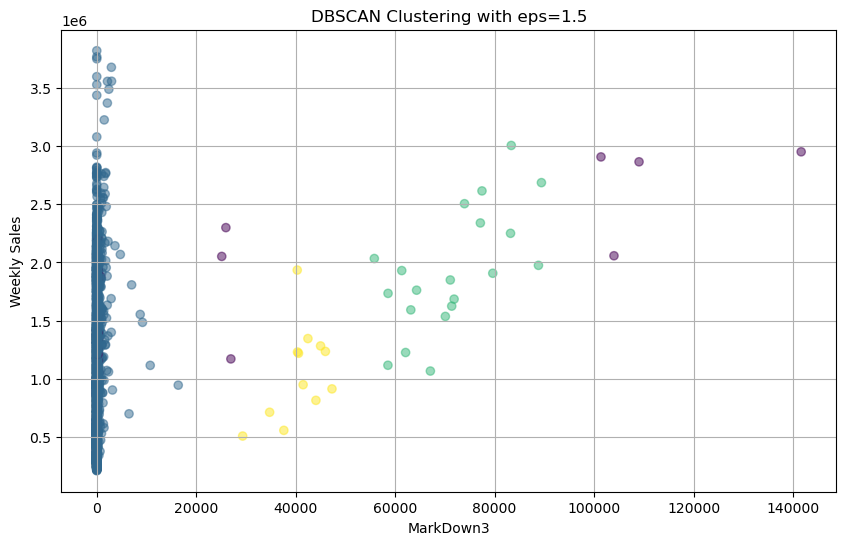

In [35]:
# Prepare data for DBSCAN
X_dbscan = merged_df[['Weekly_Sales', 'MarkDown3','MarkDown1', 'MarkDown4']]

scaler = StandardScaler()
X_dbscan_scaled = scaler.fit_transform(X_dbscan)

# Perform DBSCAN clustering
eps_values = [0.5, 1.0, 1.5, 2.0]  # Try different epsilon values
min_samples = 5  # Minimum number of points in a neighborhood to form a cluster
best_silhouette_score = -1  # Initialize the best silhouette score

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_dbscan_scaled)
    
    # Silhouette Score (only calculate if there are more than 1 cluster)
    if len(set(labels)) > 1:
        silhouette_avg = silhouette_score(X_dbscan_scaled, labels)
        print(f"DBSCAN with eps={eps}: Silhouette Score = {silhouette_avg:.3f}")
        
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_eps = eps
            best_labels = labels
    else:
        print(f"DBSCAN with eps={eps}: Only one cluster or noise points detected.")

# Output the best epsilon value
print(f"\nBest eps value based on Silhouette Score: {best_eps}")
print(f"Best Silhouette Score: {best_silhouette_score:.3f}")

# Final DBSCAN with the best eps
dbscan = DBSCAN(eps=best_eps, min_samples=min_samples)
final_labels = dbscan.fit_predict(X_dbscan_scaled)

# Add the cluster assignments to the original dataset
X_dbscan['Cluster'] = final_labels

# Print the number of clusters and noise points
n_clusters = len(set(final_labels)) - (1 if -1 in final_labels else 0)  # Exclude noise points (-1 label)
n_noise = list(final_labels).count(-1)
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_dbscan['MarkDown3'], X_dbscan['Weekly_Sales'], c=final_labels, cmap='viridis', alpha=0.5)
plt.xlabel("MarkDown3")
plt.ylabel("Weekly Sales")
plt.title(f"DBSCAN Clustering with eps={best_eps}")
plt.grid(True)
plt.show()

In [36]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Create an output directory to save the forecasts if it does not exist
output_dir = 'storePredictions'
os.makedirs(output_dir, exist_ok=True)

# Extract relevant columns from the merged dataset for store-level analysis
store_df = merged_df[['Date', 'Store', 'Weekly_Sales', 'Weighted_Weekly_Sales']]

# Reset the index to avoid using it in the DataFrame
store_df = store_df.reset_index(drop=True)

# Create a new DataFrame containing only the date, store, and weekly sales (without weighting)
unweighted_store_df = store_df[['Date', 'Store', 'Weekly_Sales']]

# Check unique store IDs to ensure we iterate through each store individually
print(unweighted_store_df['Store'].unique())

# Loop through each store in the unweighted DataFrame and apply time series forecasting
for store_id in unweighted_store_df['Store'].unique():

    # Filter data for the current store
    unweighted_df = unweighted_store_df.loc[unweighted_store_df['Store'] == store_id]

    # Set 'Date' as the index for time series forecasting
    unweighted_df.set_index('Date', inplace=True)

    # Define the target variable (weekly sales)
    y = unweighted_df['Weekly_Sales']

    # Split data into training and test sets (80% for training, 20% for testing)
    train_size = int(len(y) * 0.8)
    y_train, y_test = y[:train_size], y[train_size:]

    # Define SARIMA model orders
    sarima_order = (1, 1, 1)  # (p, d, q) - Non-seasonal order
    seasonal_order = (1, 1, 1, 52)  # (P, D, Q, S) - Seasonal order, 52 weeks for yearly seasonality

    # Initialize and fit the SARIMA model to the training data
    model = SARIMAX(y_train, order=sarima_order, seasonal_order=seasonal_order)
    sarima_fit = model.fit(disp=False)

    # Make predictions for the test set
    forecast = sarima_fit.get_forecast(steps=len(y_test))
    y_pred = forecast.predicted_mean  # Predicted weekly sales
    conf_int = forecast.conf_int()  # Confidence intervals for predictions

    # Evaluate the model's performance
    mse = mean_squared_error(y_test, y_pred)  # Mean squared error of the predictions
    correlation = np.corrcoef(y_test, y_pred)[0, 1]  # Correlation coefficient between actual and predicted values

    # Print evaluation metrics
    print(f"Mean Squared Error: {mse}")
    print(f"Correlation: {correlation}")

    # Plot the actual vs predicted weekly sales for the store
    plt.figure(figsize=(12, 6))

    # Plot training data (blue)
    plt.plot(y_train.index, y_train, label='Training Data', color='blue')

    # Plot actual test data (green)
    plt.plot(y_test.index, y_test, label='Actual Test Data', color='green')

    # Plot predicted sales (orange)
    plt.plot(y_test.index, y_pred, label='SARIMA Forecast', color='orange')

    # Plot the confidence intervals (pink shade)
    plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

    # Add title and labels to the plot
    plt.title(f'SARIMA: Actual vs Predicted Weekly Sales for Store {store_id}')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.legend()  # Show the legend for each plot line
    plt.grid(True)  # Show grid lines for better readability

    # Add the correlation value as text on the plot
    plt.text(x=0.05, y=0.95, s=f"Correlation: {correlation:.2f}", fontsize=12,
             transform=plt.gca().transAxes, color='darkred', bbox=dict(facecolor='white', alpha=0.6))

    # Save the plot as a PNG file with a unique filename for each store
    filename = os.path.join(output_dir, f'Store_{store_id}_Forecasting.png')
    plt.savefig(filename)  # Save the plot
    plt.close()  # Close the plot to free up memory for the next iteration


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
Mean Squared Error: 44069038420.63006
Correlation: 0.7582454985795363


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 29303767128.82556
Correlation: 0.5969813018918904


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 3895387598.4445276
Correlation: 0.5995276609109216


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 76280988653.22769
Correlation: 0.5040428763813325


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 3063384456.1883717
Correlation: 0.7007049247055099


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 51551142828.49953
Correlation: 0.8012125686328853


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 10650740513.477247
Correlation: 0.9359768916852098


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 4740366506.6151705
Correlation: 0.5030929174365988


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 7455666614.625906
Correlation: 0.6505933674038955


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 62782763344.49268
Correlation: 0.47147911517261193


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 41164707584.01889
Correlation: 0.46737591251527494


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 8540532379.301309
Correlation: 0.8115487277384482


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 74805968360.47127
Correlation: 0.30320155774235963


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 243945811985.16504
Correlation: 0.5372040334114896


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 5592839135.154533
Correlation: 0.7113376416233017


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 2360446424.7951055
Correlation: 0.9192594918872986


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 8301383386.625114
Correlation: 0.9163813588287293


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 14223142282.832886
Correlation: 0.36878717788528687


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 44374394205.0635
Correlation: 0.6712176834738534


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 174448283286.8354
Correlation: 0.3805992930763318


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 4272535003.3849306
Correlation: 0.7004682611693378


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 28113791678.327404
Correlation: 0.6931198868613386


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 50326664948.83166
Correlation: 0.7601633693368888


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 30759424473.872147
Correlation: 0.7954204236060981


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 13243158740.087048
Correlation: 0.49113892716119


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 10888772830.420008
Correlation: 0.8354744277216563


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 28731029531.8617
Correlation: 0.810667011271587


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 20913962065.842934
Correlation: 0.744473272435492


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 8077270286.194293
Correlation: 0.7093018473575625


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 451945345.545415
Correlation: 0.2365172959979735


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 7960321640.270901
Correlation: 0.725852999273473


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 17228236731.026035
Correlation: 0.49753137110071954


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 267733381.18951923
Correlation: 0.8299594078674041


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\base

Mean Squared Error: 5991016997.207132
Correlation: 0.5838531911768331


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 3784339175.800128
Correlation: 0.4680654201802053


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 829428301.3790162
Correlation: 0.7795471703453704


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 534162929.0211241
Correlation: 0.2370384033425785


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 3121937227.4885015
Correlation: 0.6278118712611243


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 91288842527.08919
Correlation: 0.6087183248872587


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 17876975040.39261
Correlation: 0.8492067040055515


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 17346333657.6678
Correlation: 0.7460250465389274


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\base

Mean Squared Error: 1100763307.3739924
Correlation: 0.8174123676733459


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 490857535.8571073
Correlation: 0.8026196717476364


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 190235451.00770596
Correlation: 0.38107659532561255


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 14762879964.352518
Correlation: 0.6158236369067779


In [37]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Create an output directory to save the forecasted plots if it does not exist
output_dir = 'TESForcastingPredictions'
os.makedirs(output_dir, exist_ok=True)

# Extract relevant columns for store-level analysis: Date, Store, Weekly Sales, and Weighted Weekly Sales
store_df = merged_df[['Date', 'Store', 'Weekly_Sales', 'Weighted_Weekly_Sales']]

# Loop through each store to generate forecasts
for store_id in store_df['Store'].unique():

    # Filter the data for the current store
    unweighted_store_df = store_df.loc[store_df['Store'] == store_id]
    
    # Set 'Date' as the index for time series forecasting
    unweighted_store_df.set_index('Date', inplace=True)
    
    # Define and fit the Exponential Smoothing model to the store's weekly sales data
    model = ExponentialSmoothing(
        unweighted_store_df['Weekly_Sales'],  # Target variable (weekly sales)
        seasonal='mul',  # Specify multiplicative seasonality (adjust based on your data's pattern)
        seasonal_periods=52,  # Set the seasonal period to 52 for weekly seasonality (1 year)
        trend=None  # No trend component in the model
    )
    fit = model.fit()  # Fit the model to the data
    
    # Forecast the next 52 weeks (one year)
    forecast = fit.forecast(52)
    
    # Plot the original weekly sales and the forecasted values
    plt.figure(figsize=(12, 6))
    
    # Plot original weekly sales data
    plt.plot(unweighted_store_df['Weekly_Sales'], label='Original Data')
    
    # Plot forecasted sales for the next 52 weeks
    plt.plot(forecast.index, forecast, label='Forecast', color='orange')
    
    # Add title and labels to the plot
    plt.title(f'Weekly Sales and Forecast for Store {store_id}')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.legend()  # Display legend to differentiate between the original and forecasted data
    
    # Save the forecast plot for the current store as a PNG image
    filename = os.path.join(output_dir, f'Store_{store_id}_Forecasting.png')
    plt.savefig(filename)  # Save the figure to the specified filename
    plt.close()  # Close the plot to free up memory before moving to the next store


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\si

In [38]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Create an output directory to save the forecasted plots if it does not exist
output_dir = 'TESForcastingPredictions'
os.makedirs(output_dir, exist_ok=True)

# Extract relevant columns for store-level analysis: Date, Store, Weekly Sales, and Weighted Weekly Sales
store_df = merged_df[['Date', 'Store', 'Weekly_Sales', 'Weighted_Weekly_Sales']]

# Loop through each store to generate forecasts
for store_id in store_df['Store'].unique():

    # Filter the data for the current store
    unweighted_store_df = store_df.loc[store_df['Store'] == store_id]
    
    # Set 'Date' as the index for time series forecasting
    unweighted_store_df.set_index('Date', inplace=True)
    
    # Define and fit the Exponential Smoothing model to the store's weekly sales data
    model = ExponentialSmoothing(
        unweighted_store_df['Weekly_Sales'],  # Target variable (weekly sales)
        seasonal='mul',  # Specify multiplicative seasonality (adjust based on your data's pattern)
        seasonal_periods=52,  # Set the seasonal period to 52 for weekly seasonality (1 year)
        trend=None  # No trend component in the model
    )
    fit = model.fit()  # Fit the model to the data
    
    # Forecast the next 52 weeks (one year)
    forecast = fit.forecast(52)
    
    # Plot the original weekly sales and the forecasted values
    plt.figure(figsize=(12, 6))
    
    # Plot original weekly sales data
    plt.plot(unweighted_store_df['Weekly_Sales'], label='Original Data')
    
    # Plot forecasted sales for the next 52 weeks
    plt.plot(forecast.index, forecast, label='Forecast', color='orange')
    
    # Add title and labels to the plot
    plt.title(f'Weekly Sales and Forecast for Store {store_id}')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.legend()  # Display legend to differentiate between the original and forecasted data
    
    # Save the forecast plot for the current store as a PNG image
    filename = os.path.join(output_dir, f'Store_{store_id}_Forecasting.png')
    plt.savefig(filename)  # Save the figure to the specified filename
    plt.close()  # Close the plot to free up memory before moving to the next store


c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\eric\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\eric\anaconda3\Lib\si